In [9]:
import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

In [3]:
##data preparation
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(FLAGS.dir_data, one_hot=False)

train_data = mnist.train.images.astype(np.float32)
val_data = mnist.validation.images.astype(np.float32)
test_data = mnist.test.images.astype(np.float32)
train_labels = mnist.train.labels
val_labels = mnist.validation.labels
test_labels = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../data/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [5]:
print(train_data.shape,val_data.shape,test_data.shape)
print(train_labels.shape,np.unique(train_labels))

(55000, 784) (5000, 784) (10000, 784)
(55000,) [0 1 2 3 4 5 6 7 8 9]


In [10]:
def grid_graph(m, corners=False):
    ##build a graph on minist digit images
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))
    
    plt.spy(A, markersize=2,color='black')
    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

3198 > 3136 edges
(784, 784)
Layer 0: M_0 = |V| = 944 nodes (160 added),|E| = 3196 edges
Layer 1: M_1 = |V| = 472 nodes (57 added),|E| = 1534 edges
Layer 2: M_2 = |V| = 236 nodes (20 added),|E| = 752 edges
Layer 3: M_3 = |V| = 118 nodes (3 added),|E| = 401 edges
Layer 4: M_4 = |V| = 59 nodes (0 added),|E| = 215 edges


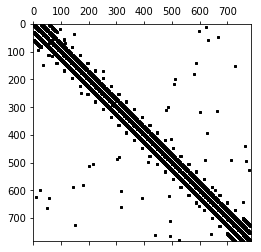

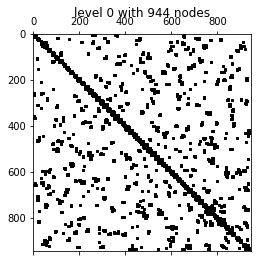

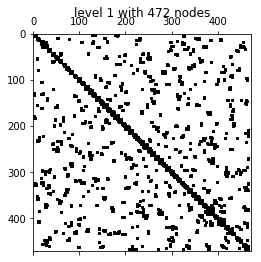

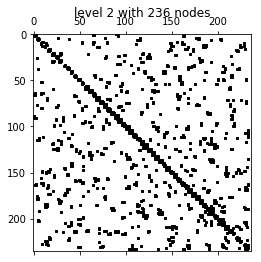

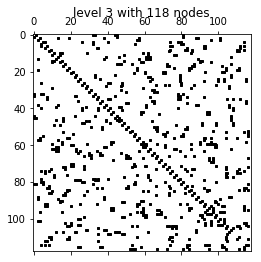

In [20]:
img_dim = 28
###cal the adjcent matrix based on euclidean distance of spatial locations
A = grid_graph(img_dim, corners=False)
A2 = graph.replace_random_edges(A, 0.01)
plt.spy(A2-A, markersize=2,color='black')
A = A2
print(A.shape)

###build multi-level graph using coarsen (div by 2 at each level)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
for li in range(FLAGS.coarsening_levels):
    plt.figure()
    plt.spy(graphs[li], markersize=2, color='black');
    plt.title('level %d with %d nodes' % (li,graphs[li].shape[0]))
    

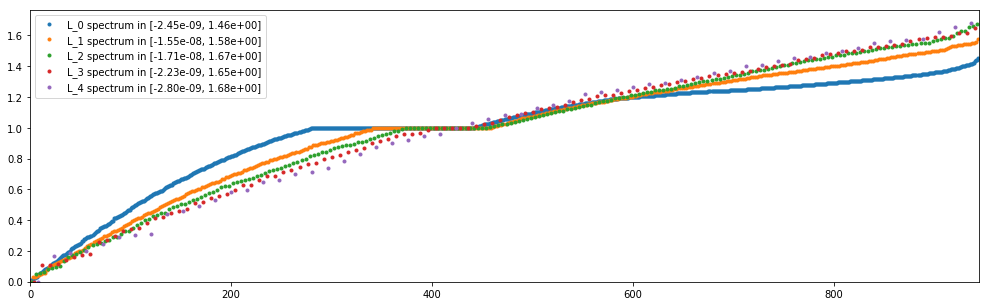

In [21]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

In [22]:
train_data_perm = coarsening.perm_data(train_data, perm)
val_data_perm = coarsening.perm_data(val_data, perm)
test_data_perm = coarsening.perm_data(test_data, perm)
print(train_data_perm.shape,val_data_perm.shape,test_data_perm.shape)
print(train_data.shape)

(55000, 944) (5000, 944) (10000, 944)
(55000, 784)


In [23]:
common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 20
common['batch_size']     = 100
common['decay_steps']    = mnist.train.num_examples / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(mnist.train.labels) + 1  # number of classes

In [26]:
model_perf = utils.model_perf()

###test different param settins
##model1: no convolution
name = 'softmax'
params = common.copy()
params['dir_name'] += name
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 0.02
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data_perm, train_labels, val_data_perm, val_labels, test_data_perm, test_labels)

NN architecture
  input: M_0 = 944
  layer 1: logits (softmax)
    representation: M_1 = 10
    weights: M_0 * M_1 = 944 * 10 = 9440
    biases: M_1 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.83e-01
  validation accuracy: 90.88 (4544 / 5000), f1 (weighted): 90.83, loss: 3.59e-01
  time: 3s (wall 3s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.56e-01
  validation accuracy: 91.70 (4585 / 5000), f1 (weighted): 91.66, loss: 3.35e-01
  time: 5s (wall 5s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 3.28e-01
  validation accuracy: 91.94 (4597 / 5000), f1 (weighted): 91.91, loss: 3.26e-01
  time: 7s (wall 6s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 3.65e-01
  validation accuracy: 92.36 (4618 / 5000), f1 (weighted): 92.35, loss: 3.23e-01
  time: 9s (wall 7s)
step 3000 / 11000 (epoch 5.45 / 20):
  learning_rate = 1.55e-02, loss_average = 3.4

In [27]:
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.02
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [10]  # Number of graph convolutional filters.
common['K']              = [20]  # Polynomial orders.
common['p']              = [1]  # Pooling sizes.
common['M']              = [C] # Output dimensionality of fully connected layers.

###model#2: one-layer convolution with fourier transform as filter
name = 'fgconv_softmax'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'fourier'
params['K'] = [L[0].shape[0]]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data_perm, train_labels, val_data_perm, val_labels, test_data_perm, test_labels)

NN architecture
  input: M_0 = 944
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 944 * 10 / 1 = 9440
    weights: F_0 * F_1 * K_1 = 1 * 10 * 944 = 9440
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9440 * 10 = 94400
    biases: M_2 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.71e-01
  validation accuracy: 89.26 (4463 / 5000), f1 (weighted): 89.20, loss: 3.60e-01
  time: 3s (wall 3s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.12e-01
  validation accuracy: 91.08 (4554 / 5000), f1 (weighted): 91.05, loss: 3.07e-01
  time: 6s (wall 6s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 2.67e-01
  validation accuracy: 92.16 (4608 / 5000), f1 (weighted): 92.13, loss: 2.74e-01
  time: 9s (wall 9s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 2.88e-01
  validation accuracy: 93.24 (4662

In [28]:
## model#3: one-layer convolution with spline basis as filter
name = 'sgconv_softmax'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'spline'
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data_perm, train_labels, val_data_perm, val_labels, test_data_perm, test_labels)

NN architecture
  input: M_0 = 944
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 944 * 10 / 1 = 9440
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9440 * 10 = 94400
    biases: M_2 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.32e-01
  validation accuracy: 90.04 (4502 / 5000), f1 (weighted): 89.99, loss: 3.33e-01
  time: 3s (wall 3s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.26e-01
  validation accuracy: 91.40 (4570 / 5000), f1 (weighted): 91.36, loss: 2.93e-01
  time: 7s (wall 6s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 2.94e-01
  validation accuracy: 91.78 (4589 / 5000), f1 (weighted): 91.79, loss: 2.82e-01
  time: 10s (wall 10s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 2.90e-01
  validation accuracy: 92.26 (4613

In [29]:
##model#4: one-layer convolution with chebyshev5 and b1relu as filters
name = 'cgconv_softmax'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'chebyshev5'
#    params['filter'] = 'chebyshev2'
#    params['brelu'] = 'b2relu'
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data_perm, train_labels, val_data_perm, val_labels, test_data_perm, test_labels)

NN architecture
  input: M_0 = 944
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 944 * 10 / 1 = 9440
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9440 * 10 = 94400
    biases: M_2 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 1.39e-01
  validation accuracy: 96.06 (4803 / 5000), f1 (weighted): 96.07, loss: 1.36e-01
  time: 4s (wall 3s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 1.30e-01
  validation accuracy: 97.14 (4857 / 5000), f1 (weighted): 97.14, loss: 1.02e-01
  time: 8s (wall 7s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 8.04e-02
  validation accuracy: 97.10 (4855 / 5000), f1 (weighted): 97.10, loss: 9.47e-02
  time: 11s (wall 11s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 6.67e-02
  validation accuracy: 97.58 (4879

In [30]:
##model#4: one-layer convolution with chebyshev2 and b2relu as filters
name = 'cgconv_softmax'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'chebyshev2'
params['brelu'] = 'b2relu'
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data_perm, train_labels, val_data_perm, val_labels, test_data_perm, test_labels)

NN architecture
  input: M_0 = 944
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 944 * 10 / 1 = 9440
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: M_1 * F_1 = 944 * 10 = 9440
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9440 * 10 = 94400
    biases: M_2 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 1.35e-01
  validation accuracy: 96.36 (4818 / 5000), f1 (weighted): 96.36, loss: 1.25e-01
  time: 12s (wall 12s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 9.14e-02
  validation accuracy: 96.88 (4844 / 5000), f1 (weighted): 96.88, loss: 9.60e-02
  time: 24s (wall 25s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 8.51e-02
  validation accuracy: 97.54 (4877 / 5000), f1 (weighted): 97.54, loss: 8.07e-02
  time: 36s (wall 37s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 7.19e-02
  validatio

In [34]:
# Common hyper-parameters for LeNet5-like networks (two convolutional layers).
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64]  # Number of graph convolutional filters.
common['K']              = [25, 25]  # Polynomial orders.
common['p']              = [4, 4]    # Pooling sizes.
common['M']              = [512, C]  # Output dimensionality of fully connected layers.

##model#1: two convolutional layers with fourier transform as filters
name = 'fgconv_fgconv_fc_softmax' #  'Non-Param'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'fourier'
params['K'] = [L[0].shape[0], L[2].shape[0]]
print([L[li].shape for li in range(len(L))])

t_start = time.process_time()
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data_perm, train_labels, val_data_perm, val_labels, test_data_perm, test_labels)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))

[(944, 944), (472, 472), (236, 236), (118, 118), (59, 59)]
NN architecture
  input: M_0 = 944
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 944 * 32 / 4 = 7552
    weights: F_0 * F_1 * K_1 = 1 * 32 * 944 = 30208
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 236 * 64 / 4 = 3776
    weights: F_1 * F_2 * K_2 = 32 * 64 * 236 = 483328
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3776 * 512 = 1933312
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.84e+00
  validation accuracy: 87.26 (4363 / 5000), f1 (weighted): 87.15, loss: 3.77e+00
  time: 6s (wall 9s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.37e+00
  validation accuracy: 91.04 (4552 / 5000), f1 (weighted): 91.02, loss: 3.30e+00
  time: 12s 

In [35]:
##model#2: two convolutional layers with spline basis as filters
name = 'sgconv_sgconv_fc_softmax' #  'Non-Param'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'spline'
print(params)
print([L[li].shape for li in range(len(L))])

t_start = time.process_time()
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data_perm, train_labels, val_data_perm, val_labels, test_data_perm, test_labels)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))

{'decay_steps': 550.0, 'num_epochs': 20, 'decay_rate': 0.95, 'dir_name': 'mnist/sgconv_sgconv_fc_softmax', 'p': [4, 4], 'learning_rate': 0.02, 'pool': 'mpool1', 'momentum': 0.9, 'eval_frequency': 600, 'regularization': 0.0005, 'M': [512, 10], 'dropout': 0.5, 'K': [25, 25], 'batch_size': 100, 'brelu': 'b1relu', 'filter': 'spline', 'F': [32, 64]}
[(944, 944), (472, 472), (236, 236), (118, 118), (59, 59)]
NN architecture
  input: M_0 = 944
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 944 * 32 / 4 = 7552
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 236 * 64 / 4 = 3776
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3776 * 512 = 1933312
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
step 600 / 11000 (epoch 1.09 /

In [37]:
##model#3: two convolutional layers with Chebyshev polynomial as filters
name = 'cgconv_cgconv_fc_softmax' #  'Non-Param'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'chebyshev5'
print(params)
print([L[li].shape for li in range(len(L))])

t_start = time.process_time()
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data_perm, train_labels, val_data_perm, val_labels, test_data_perm, test_labels)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))

{'decay_steps': 550.0, 'num_epochs': 20, 'decay_rate': 0.95, 'dir_name': 'mnist/cgconv_cgconv_fc_softmax', 'p': [4, 4], 'learning_rate': 0.02, 'pool': 'mpool1', 'momentum': 0.9, 'eval_frequency': 600, 'regularization': 0.0005, 'M': [512, 10], 'dropout': 0.5, 'K': [25, 25], 'batch_size': 100, 'brelu': 'b1relu', 'filter': 'chebyshev5', 'F': [32, 64]}
[(944, 944), (472, 472), (236, 236), (118, 118), (59, 59)]
NN architecture
  input: M_0 = 944
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 944 * 32 / 4 = 7552
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 236 * 64 / 4 = 3776
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3776 * 512 = 1933312
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
step 600 / 11000 (epoch 1.

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
98.89 99.83   98.89 99.83   9.75e-01 9.47e-01    96   cgconv_cgconv_fc_softmax
98.19 99.51   98.19 99.51   5.66e-02 2.03e-02    20   cgconv_softmax
96.60 96.79   96.60 96.79   1.08e+00 1.08e+00    18   fgconv_fgconv_fc_softmax
95.80 95.79   95.80 95.79   1.45e-01 1.46e-01     6   fgconv_softmax
98.04 98.54   98.04 98.54   1.02e+00 1.00e+00    18   sgconv_sgconv_fc_softmax
93.70 94.01   93.68 94.00   2.23e-01 2.16e-01     6   sgconv_softmax
92.20 92.48   92.18 92.46   3.15e-01 3.13e-01     3   softmax


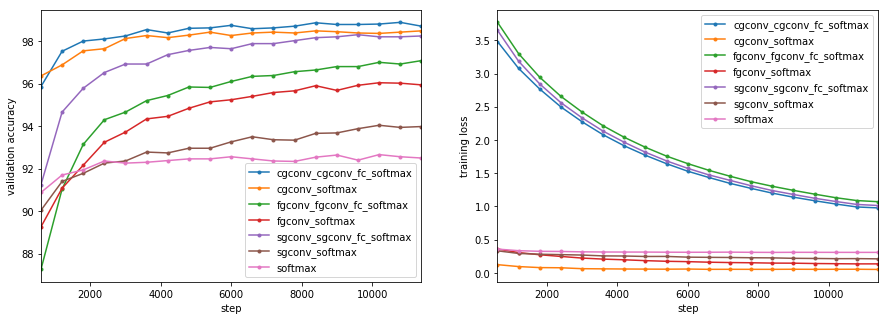

In [38]:
model_perf.show()

In [41]:
from lib import utils
grid_params = {}
data = (train_data_perm, train_labels, val_data_perm, val_labels, test_data_perm, test_labels)
utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))


AttributeError: module 'sklearn' has no attribute 'grid_search'